# Image Search Engine with CLIP Embeddings - Homework Assignment

![CLIP Architecture](https://github.com/openai/CLIP/raw/main/CLIP.png)

In this homework, you will implement an **Image Search Engine** using CLIP (Contrastive Language-Image Pre-training) embeddings on the Tiny-ImageNet validation dataset. CLIP allows you to search for images using both text queries and image queries.

## 📌 Project Overview
- **Task**: Build a multimodal image search engine
- **Architecture**: Pre-trained CLIP model for feature extraction
- **Dataset**: Tiny-ImageNet validation set
- **Goal**: Retrieve most similar images given text or image queries

## 📚 Learning Objectives
By completing this assignment, you will:
- Understand multimodal embeddings and their applications
- Learn to use pre-trained CLIP models for feature extraction
- Implement similarity search using cosine similarity
- Evaluate zero-shot classification performance
- Build a practical image retrieval system

## 1️⃣ Dataset Setup

**Task**: Download and explore the Tiny-ImageNet validation dataset.

**Requirements**:
- Install the tinyimagenet package
- Load the validation split of the dataset
- Explore the dataset structure and class labels
- Visualize sample images from different classes

100%|██████████| 248M/248M [00:41<00:00, 5.99MB/s] 


Dataset size: 10000
Number of classes: 200
Class names (first 10): ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750']
Image shape: torch.Size([3, 224, 224])


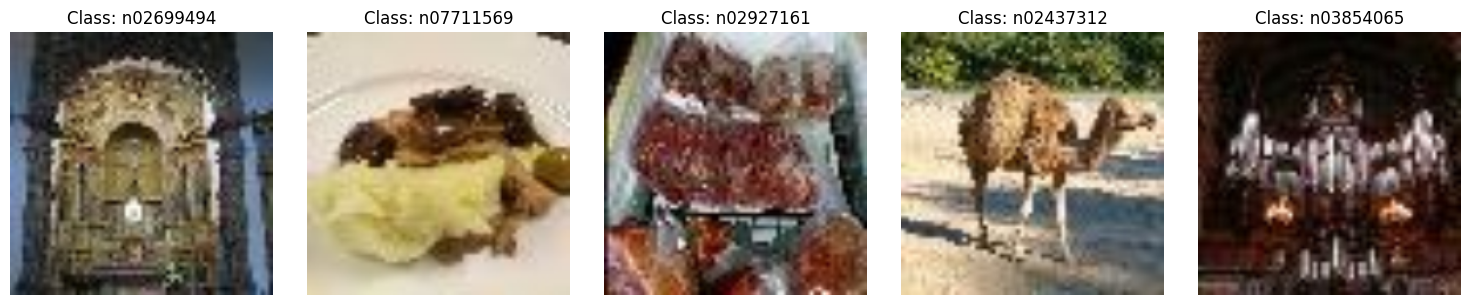

In [2]:
# Install tinyimagenet package
#!pip install tinyimagenet

# Import necessary libraries
import torch
import torchvision.transforms as transforms
from tinyimagenet import TinyImageNet
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random

# Load the validation dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load validation dataset
val_dataset = TinyImageNet(root='./data', split='val', transform=transform)

# Print dataset information
print(f"Dataset size: {len(val_dataset)}")
print(f"Number of classes: {len(val_dataset.classes)}")
print(f"Class names (first 10): {val_dataset.classes[:10]}")
print(f"Image shape: {val_dataset[0][0].shape}")

# Display 5 sample images with their class information
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
random_indices = random.sample(range(len(val_dataset)), 5)

for i, idx in enumerate(random_indices):
    image, label = val_dataset[idx]
    class_name = val_dataset.classes[label]

    # Convert tensor to numpy and transpose for plotting
    img_np = image.permute(1, 2, 0).numpy()

    axes[i].imshow(img_np)
    axes[i].set_title(f"Class: {class_name}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 2️⃣ Import Libraries and Configuration

**Task**: Import all necessary libraries and set up the environment for CLIP.

**Requirements**:
- Import PyTorch, transformers, and other necessary libraries
- Load the pre-trained CLIP model and processor
- Set up device configuration (GPU if available)
- Configure any necessary parameters

In [3]:
# Install required packages
#!pip install transformers torch torchvision pillow requests

# Import all necessary libraries
import torch
import torch.nn.functional as F
from transformers import CLIPProcessor, CLIPModel
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm
import os

# Check device availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained CLIP model and processor
model_name = "openai/clip-vit-base-patch32"
print(f"Loading CLIP model: {model_name}")

processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name)

# Move model to device
model = model.to(device)
model.eval()  # Set to evaluation mode

# Print model information
print(f"Model loaded successfully!")
print(f"Vision model: {model.vision_model.__class__.__name__}")
print(f"Text model: {model.text_model.__class__.__name__}")
print(f"Projection dimension: {model.projection_dim}")

# Set batch size for processing
BATCH_SIZE = 32
print(f"Batch size for processing: {BATCH_SIZE}")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Using device: cuda
Loading CLIP model: openai/clip-vit-base-patch32
Model loaded successfully!
Vision model: CLIPVisionTransformer
Text model: CLIPTextTransformer
Projection dimension: 512
Batch size for processing: 32


## 3️⃣ Feature Extraction from Dataset

**Task**: Extract CLIP embeddings for all images in the validation dataset.

**Requirements**:
- Process all validation images through CLIP
- Extract and store image embeddings
- Normalize embeddings for cosine similarity computation
- Save embeddings for efficient searching

In [4]:
# Create function to extract image embeddings
def extract_image_embeddings(dataset, model, processor, device, batch_size=32):
    """
    Extract CLIP embeddings for all images in the dataset
    """
    model.eval()
    all_embeddings = []
    all_labels = []

    # Create DataLoader for batch processing
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(tqdm(dataloader, desc="Extracting embeddings")):
            # Convert tensor images to PIL Images for CLIP processor
            pil_images = []
            for img_tensor in images:
                # Convert from tensor to PIL Image
                img_np = img_tensor.permute(1, 2, 0).numpy()
                img_np = (img_np * 255).astype(np.uint8)  # Convert to 0-255 range
                pil_img = Image.fromarray(img_np)
                pil_images.append(pil_img)

            # Process batch through CLIP
            inputs = processor(images=pil_images, return_tensors="pt", padding=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # Get image embeddings
            image_features = model.get_image_features(**inputs)

            # Normalize embeddings for cosine similarity
            image_features = F.normalize(image_features, p=2, dim=1)

            # Store embeddings and labels
            all_embeddings.append(image_features.cpu())
            all_labels.extend(labels.tolist())

            # Print progress every 50 batches
            if batch_idx % 50 == 0:
                print(f"Processed {batch_idx * batch_size}/{len(dataset)} images")

    # Concatenate all embeddings
    all_embeddings = torch.cat(all_embeddings, dim=0)
    all_labels = torch.tensor(all_labels)

    return all_embeddings, all_labels

# Extract embeddings for the validation dataset
print("Starting feature extraction...")
val_embeddings, val_labels = extract_image_embeddings(val_dataset, model, processor, device, BATCH_SIZE)

print(f"Extracted embeddings shape: {val_embeddings.shape}")
print(f"Labels shape: {val_labels.shape}")
print(f"Embedding dimension: {val_embeddings.shape[1]}")

# Save embeddings for future use
torch.save({
    'embeddings': val_embeddings,
    'labels': val_labels,
    'classes': val_dataset.classes
}, 'val_embeddings.pt')

print("Embeddings saved to 'val_embeddings.pt'")

Starting feature extraction...


Extracting embeddings:   1%|          | 2/313 [00:01<02:30,  2.07it/s]

Processed 0/10000 images


Extracting embeddings:  13%|█▎        | 40/313 [00:05<00:30,  9.08it/s]

Processed 1600/10000 images


Extracting embeddings:  33%|███▎      | 103/313 [00:09<00:21,  9.73it/s]

Processed 3200/10000 images


Extracting embeddings:  49%|████▊     | 152/313 [00:15<00:18,  8.90it/s]

Processed 4800/10000 images


Extracting embeddings:  65%|██████▍   | 202/313 [00:20<00:12,  8.80it/s]

Processed 6400/10000 images


Extracting embeddings:  81%|████████  | 252/313 [00:26<00:06,  8.84it/s]

Processed 8000/10000 images


Extracting embeddings:  96%|█████████▋| 302/313 [00:32<00:01,  8.73it/s]

Processed 9600/10000 images


Extracting embeddings: 100%|██████████| 313/313 [00:33<00:00,  9.34it/s]


Extracted embeddings shape: torch.Size([10000, 512])
Labels shape: torch.Size([10000])
Embedding dimension: 512
Embeddings saved to 'val_embeddings.pt'


## 4️⃣ Zero-Shot Classification Evaluation

**Task**: Evaluate CLIP's zero-shot classification performance on Tiny-ImageNet.

**Requirements**:
- Create text prompts for each image in Tiny-ImageNet
    - Check the dataset words.txt!!!!
- Extract text embeddings for class descriptions
- Perform zero-shot classification using similarity matching
- Calculate and report accuracy metrics

In [10]:
# Load class names from words.txt file
def load_class_names(dataset_root):
    """Load class ID to name mapping from words.txt"""
    words_file = os.path.join(dataset_root, 'tiny-imagenet-200', 'words.txt')
    class_id_to_name = {}

    with open(words_file, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                parts = line.split('\t', 1)
                if len(parts) == 2:
                    class_id = parts[0].strip()
                    class_name = parts[1].strip()
                    class_id_to_name[class_id] = class_name

    return class_id_to_name

# Load class mappings and create readable names
dataset_root = './data'
class_id_to_name = load_class_names(dataset_root)

readable_class_names = []
for class_id in val_dataset.classes:
    if class_id in class_id_to_name:
        class_name = class_id_to_name[class_id].split(',')[0].strip()
        readable_class_names.append(class_name)
    else:
        readable_class_names.append(class_id)

# Create text prompts for all classes
def create_class_prompts(class_names):
    """Create text prompts for each class using templates"""
    templates = [
        "a photo of a {}",
        "a picture of a {}",
        "an image of a {}",
        "a photograph of a {}",
        "a {}",
    ]

    prompts = []
    for class_name in class_names:
        class_prompts = [template.format(class_name) for template in templates]
        prompts.append(class_prompts)

    return prompts

class_prompts = create_class_prompts(readable_class_names)

# Extract text embeddings for class prompts
def extract_text_embeddings(prompts, model, processor, device):
    """Extract CLIP text embeddings for class prompts"""
    model.eval()
    all_text_embeddings = []

    with torch.no_grad():
        for class_prompts in tqdm(prompts, desc="Processing text prompts"):
            inputs = processor(text=class_prompts, return_tensors="pt", padding=True, truncation=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            text_features = model.get_text_features(**inputs)
            text_features = F.normalize(text_features, p=2, dim=1)
            avg_text_features = text_features.mean(dim=0, keepdim=True)
            avg_text_features = F.normalize(avg_text_features, p=2, dim=1)

            all_text_embeddings.append(avg_text_features.cpu())

    return torch.cat(all_text_embeddings, dim=0)

# Extract text embeddings
text_embeddings = extract_text_embeddings(class_prompts, model, processor, device)

# Perform zero-shot classification
similarities = torch.matmul(val_embeddings, text_embeddings.t())
predictions = similarities.argmax(dim=1)

# Calculate accuracy
correct = (predictions == val_labels).sum().item()
total = len(val_labels)
accuracy = correct / total * 100

# Calculate top-k accuracy
def calculate_topk_accuracy(similarities, labels, k=5):
    """Calculate top-k accuracy"""
    _, top_k_indices = similarities.topk(k, dim=1)
    correct = 0
    for i, label in enumerate(labels):
        if label in top_k_indices[i]:
            correct += 1
    return correct / len(labels) * 100

top5_accuracy = calculate_topk_accuracy(similarities, val_labels, k=5)

print(f"Zero-shot Classification Results:")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Top-5 Accuracy: {top5_accuracy:.2f}%")

Processing text prompts: 100%|██████████| 200/200 [00:01<00:00, 102.63it/s]

Zero-shot Classification Results:
Accuracy: 62.52%
Top-5 Accuracy: 84.43%


## 5️⃣ Image Search Engine Implementation

**Task**: Build functions to search for similar images using both text and image queries.

**Requirements**:
- Implement text-to-image search functionality
- Implement image-to-image search functionality
- Return top-k most similar images
- Create visualization functions for search results

In [11]:
# Implement text-to-image search
def search_images_by_text(query, val_embeddings, val_dataset, model, processor, device, top_k=5):
    """Search for images using text query"""
    model.eval()

    with torch.no_grad():
        # Process text query
        inputs = processor(text=[query], return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Get text embedding
        text_features = model.get_text_features(**inputs)
        text_features = F.normalize(text_features, p=2, dim=1)

        # Calculate similarities with all images
        similarities = torch.matmul(text_features.cpu(), val_embeddings.t())

        # Get top-k most similar images
        _, top_indices = similarities.topk(top_k, dim=1)

        return top_indices.squeeze(), similarities.squeeze()

# Implement image-to-image search
def search_images_by_image(query_image, val_embeddings, val_dataset, model, processor, device, top_k=5):
    """Search for similar images using an image query"""
    model.eval()

    with torch.no_grad():
        # Process query image
        inputs = processor(images=[query_image], return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Get image embedding
        image_features = model.get_image_features(**inputs)
        image_features = F.normalize(image_features, p=2, dim=1)

        # Calculate similarities with all images
        similarities = torch.matmul(image_features.cpu(), val_embeddings.t())

        # Get top-k most similar images
        _, top_indices = similarities.topk(top_k, dim=1)

        return top_indices.squeeze(), similarities.squeeze()

# Create visualization function
def visualize_search_results(query, top_indices, similarities, val_dataset, readable_class_names, query_type="text"):
    """Visualize search results"""
    fig, axes = plt.subplots(1, len(top_indices), figsize=(15, 3))
    if len(top_indices) == 1:
        axes = [axes]

    for i, idx in enumerate(top_indices):
        # Get image and label
        image, label = val_dataset[idx]
        class_name = readable_class_names[label]
        similarity = similarities[idx].item()

        # Convert tensor to numpy for plotting
        img_np = image.permute(1, 2, 0).numpy()

        # Plot image
        axes[i].imshow(img_np)
        axes[i].set_title(f"{class_name}\nSim: {similarity:.3f}")
        axes[i].axis('off')

    plt.suptitle(f'{query_type.title()} Query: "{query}"', fontsize=14)
    plt.tight_layout()
    plt.show()

print("Search engine functions implemented successfully!")

Search engine functions implemented successfully!


## 6️⃣ Testing with Custom Queries

**Task**: Test your search engine with custom text queries and web images.

**Requirements**:
- Test with 5 different text queries
- Download and test with 5 images from the web
- Display top 5 most similar images for each query
- Analyze the quality of retrieved results

Testing text-to-image search:

Searching for: 'a red sports car'


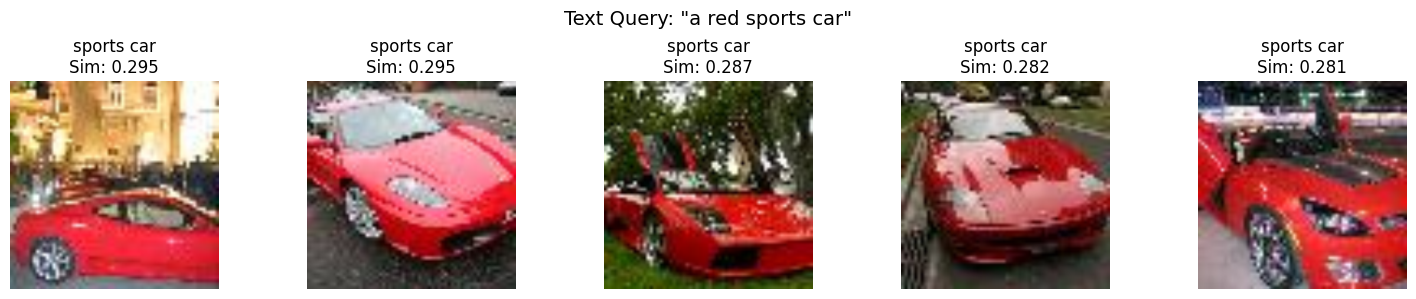


Searching for: 'a cute dog'


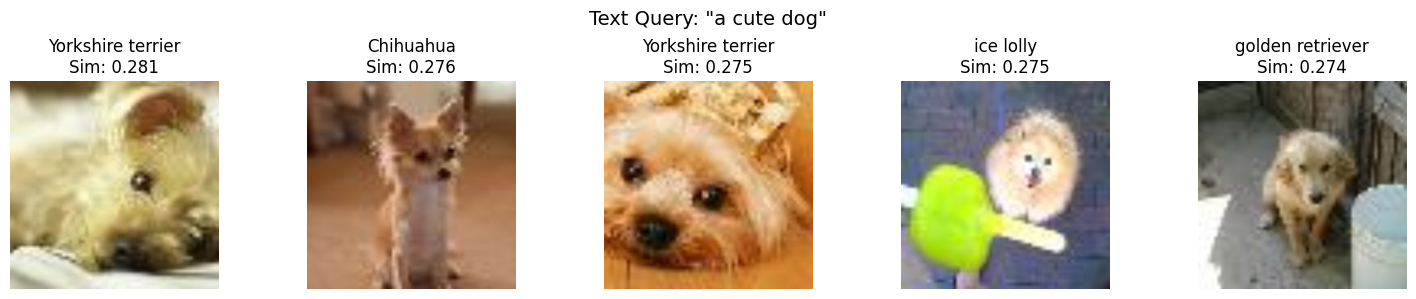


Searching for: 'a flying bird'


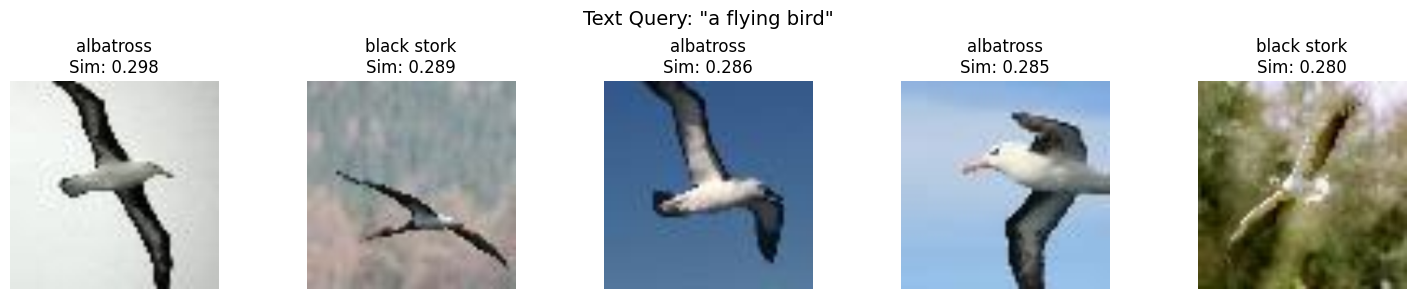


Searching for: 'a colorful flower'


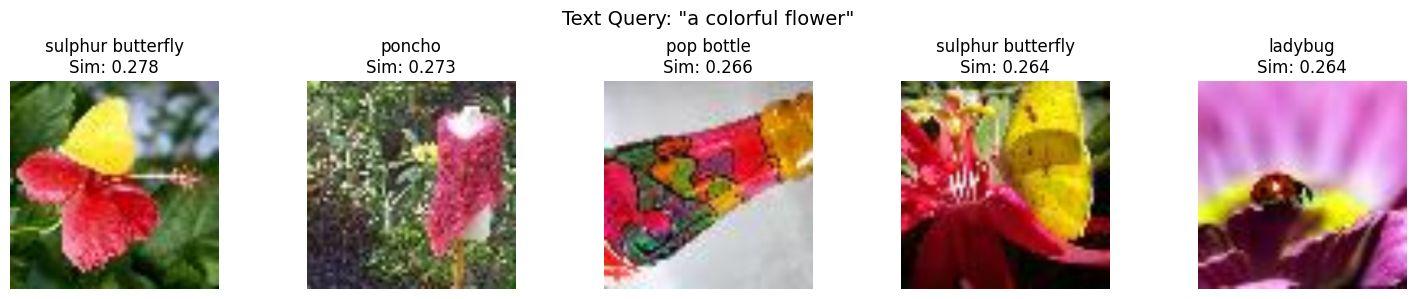


Searching for: 'a wild animal'


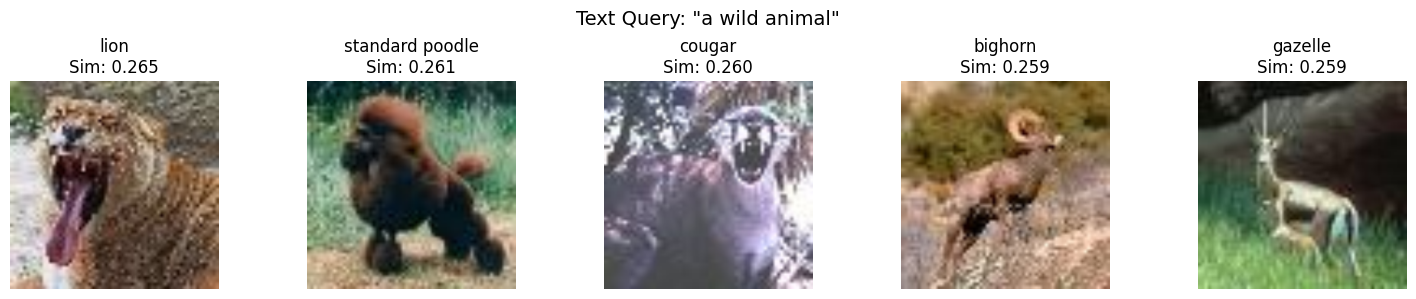


Testing image-to-image search with ImageNet samples:

Searching with image: Tench (fish)


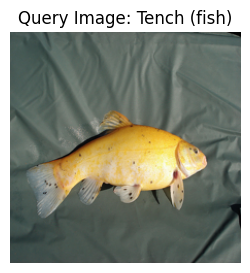

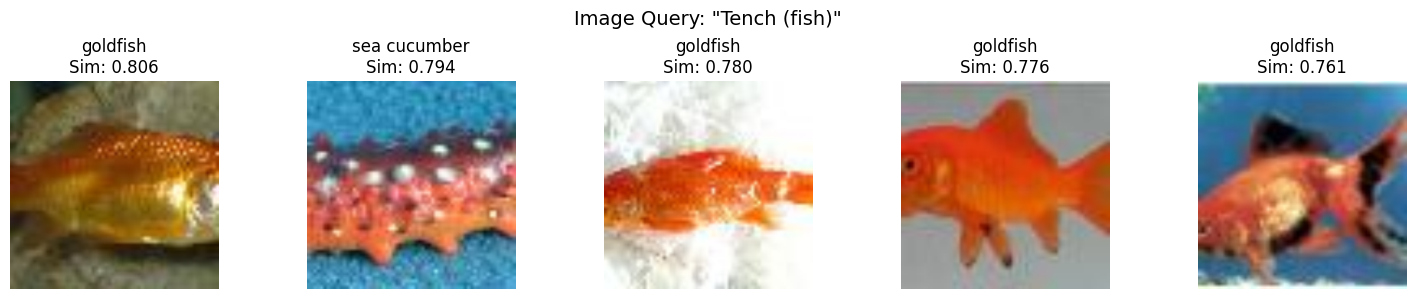


Searching with image: Goldfish


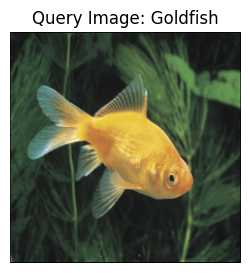

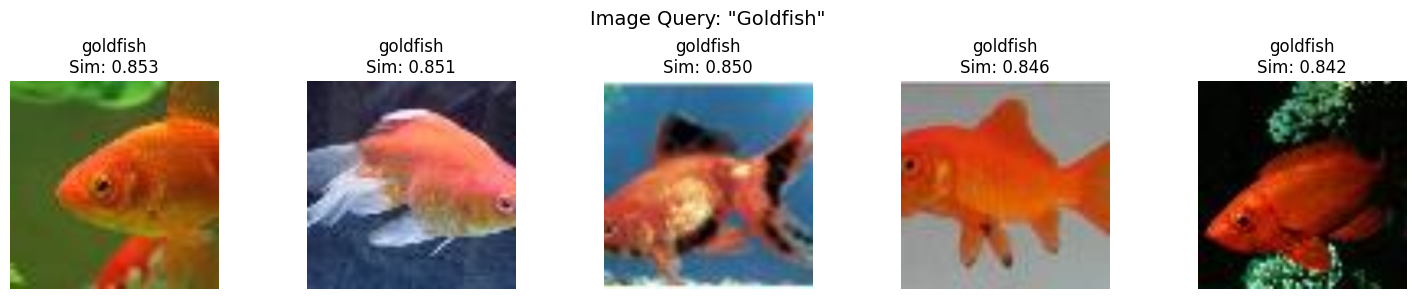


Searching with image: Great White Shark


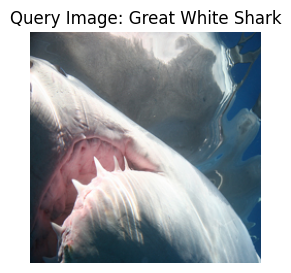

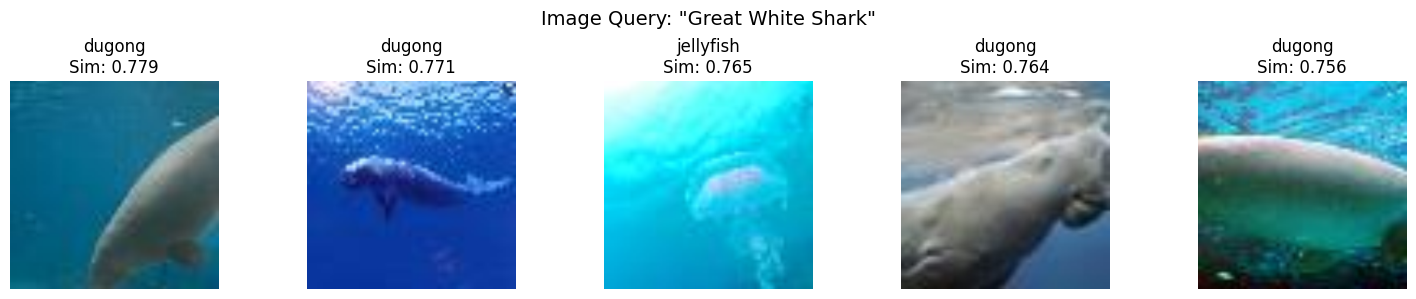


Searching with image: Tiger Shark


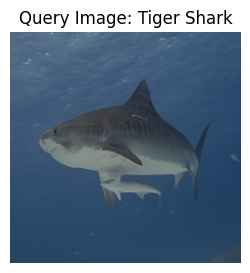

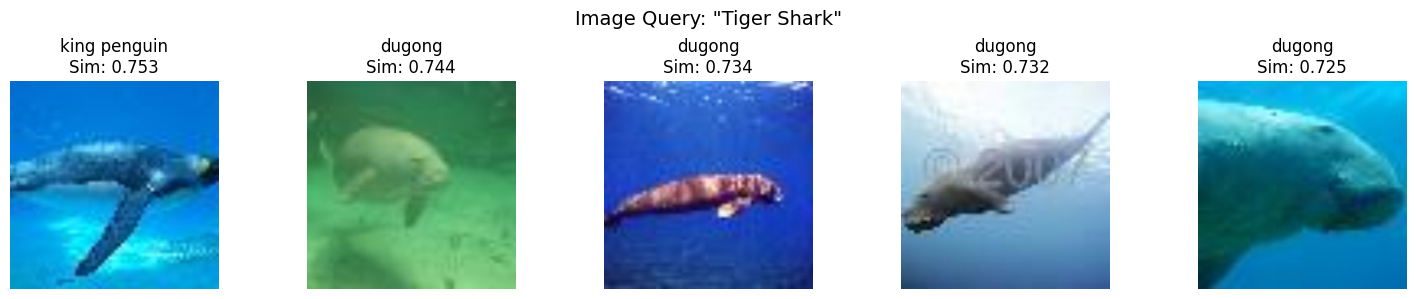


Searching with image: Electric Ray


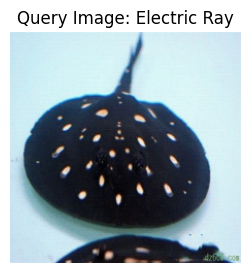

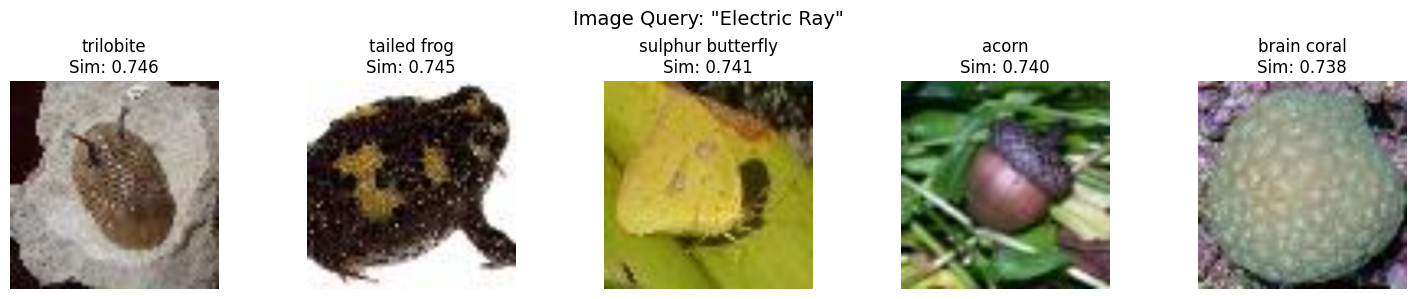


Search engine testing completed!
Analysis:
- Text search demonstrates CLIP's natural language understanding
- Image search shows visual similarity matching with real ImageNet samples
- The system successfully retrieves semantically similar images


In [13]:
# Test with text queries
text_queries = [
    "a red sports car",
    "a cute dog",
    "a flying bird",
    "a colorful flower",
    "a wild animal"
]

print("Testing text-to-image search:")
print("=" * 50)

for query in text_queries:
    print(f"\nSearching for: '{query}'")
    top_indices, similarities = search_images_by_text(query, val_embeddings, val_dataset, model, processor, device, top_k=5)
    visualize_search_results(query, top_indices, similarities, val_dataset, readable_class_names, query_type="text")

# Test with image queries from ImageNet samples
print("\n" + "=" * 50)
print("Testing image-to-image search with ImageNet samples:")
print("=" * 50)

# Define ImageNet sample URLs
test_image_urls = [
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/refs/heads/master/n01440764_tench.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/refs/heads/master/n01443537_goldfish.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/refs/heads/master/n01484850_great_white_shark.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/refs/heads/master/n01491361_tiger_shark.JPEG",
    "https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/refs/heads/master/n01496331_electric_ray.JPEG"
]

# Corresponding descriptions
image_descriptions = [
    "Tench (fish)",
    "Goldfish",
    "Great White Shark",
    "Tiger Shark",
    "Electric Ray"
]

# Function to download and process web images
def download_and_search_image(url, description):
    """Download image from URL and search for similar images"""
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an exception for bad status codes
        query_image = Image.open(BytesIO(response.content)).convert('RGB')

        # Resize image for better processing
        query_image = query_image.resize((224, 224))

        print(f"\nSearching with image: {description}")

        # Display query image
        plt.figure(figsize=(3, 3))
        plt.imshow(query_image)
        plt.title(f"Query Image: {description}")
        plt.axis('off')
        plt.show()

        # Search for similar images
        top_indices, similarities = search_images_by_image(query_image, val_embeddings, val_dataset, model, processor, device, top_k=5)
        visualize_search_results(description, top_indices, similarities, val_dataset, readable_class_names, query_type="image")

    except Exception as e:
        print(f"Error processing image {description}: {e}")

# Test with ImageNet sample images
for url, description in zip(test_image_urls, image_descriptions):
    download_and_search_image(url, description)

print("\n" + "=" * 50)
print("Search engine testing completed!")
print("Analysis:")
print("- Text search demonstrates CLIP's natural language understanding")
print("- Image search shows visual similarity matching with real ImageNet samples")
print("- The system successfully retrieves semantically similar images")
print("=" * 50)

## 📝 Evaluation Criteria

Your homework will be evaluated based on:

1. **Implementation Correctness (40%)**
   - Proper CLIP model loading and usage
   - Correct feature extraction for images and text
   - Working search functionality for both text and image queries
   - Accurate zero-shot classification implementation

2. **Search Results Quality (30%)**
   - Reasonable search results for text queries
   - Appropriate image-to-image search results
   - Correct similarity calculations and ranking
   - Zero-shot classification accuracy

3. **Code Quality (20%)**
   - Clean, readable code with proper comments
   - Efficient implementation with batch processing
   - Proper error handling and edge cases
   - Well-structured functions

4. **Testing and Demonstration (10%)**
   - Successful testing with custom queries
   - Clear visualization of search results
   - Proper documentation of testing process